<a href="https://colab.research.google.com/github/Susendramusani/susendra143/blob/main/Susendra_DSCI_6004_F24_Assignment3_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Word Embeddings with War and Peace Dataset

Welcome to this programming assignment where you will compute word embeddings using the *"War and Peace"* dataset.

In this assignment, you will practice how to compute word embeddings and use them for sentiment analysis and word representation.

By completing this assignment you will:
- Train word vectors from scratch.
- Learn how to create batches of data.
- Understand how backpropagation works.
- Plot and visualize your learned word vectors.


## Outline

- [1 The Continuous bag of words model](#1)
- [2 Training the Model](#2)
    - [2.0 Initialize the model](#2)
        - [Exercise 01](#ex-01)
    - [2.1 Softmax Function](#2.1)
        - [Exercise 02](#ex-02)
    - [2.2 Forward Propagation](#2.2)
        - [Exercise 03](#ex-03)
    - [2.3 Cost Function](#2.3)
    - [2.4 Backproagation](#2.4)
        - [Exercise 04](#ex-04)
    - [2.5 Gradient Descent](#2.5)
        - [Exercise 05](#ex-05)
- [3 Visualizing the word vectors](#3)


<a name='1'></a>
# 1. The Continuous bag of words model

Let's take a look at the following sentence:
>**'I am happy because I am learning'**.

- In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
- For example, if you were to choose a context half-size of say $C = 2$, then you would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

> $C$ words before: [I, am]

> $C$ words after: [because, I]

- In other words:

$$context = [I,am, because, I]$$
$$target = happy$$

The structure of your model will look like this:

<div style="width:image width px; font-size:100%; text-align:center;"><img src='word2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 1 </div>

Where $\bar x$ is the average of all the one hot vectors of the context words.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='mean_vec2.png' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /> Figure 2 </div>

Once you have encoded all the context words, you can use $\bar x$ as the input to your model.

The architecture you will be implementing is as follows:

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
 \hat y &= softmax(z)   \tag{4} \\
\end{align}

In [1]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:

# Import necessary Python libraries and helper functions
import nltk
import numpy as np
import requests
from nltk.tokenize import word_tokenize
from collections import Counter
import re

nltk.download('punkt')

# Download the War and Peace dataset from Project Gutenberg
url = "https://www.gutenberg.org/files/2600/2600-0.txt"
response = requests.get(url)
text = response.text

# Preprocess the text: remove headers/footers and clean the text
start = text.find("BOOK ONE: 1805")
end = text.find("End of the Project Gutenberg")
text = text[start:end]

# Replace punctuations with spaces, convert to lowercase, and tokenize
text = re.sub(r'[,!?;-]', ' ', text.lower())
tokens = word_tokenize(text)

# Filter out non-alphabetical tokens and limit to 61,000 tokens for computational efficiency
tokens = [word for word in tokens if word.isalpha()][:61000]
vocab = set(tokens)

# Print stats
print(f"Number of tokens: {len(tokens)}")
print(f"Size of vocabulary: {len(vocab)}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Number of tokens: 61000
Size of vocabulary: 5958


In [3]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [4]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in tokens)
print("Size of vocabulary: ", len(fdist))
print("Most frequent tokens: ", fdist.most_common(300))  # print the 20 most frequent words and their frequencies


Size of vocabulary:  5958
Most frequent tokens:  [('the', 3697), ('and', 2244), ('to', 1794), ('of', 1309), ('a', 1270), ('his', 999), ('he', 970), ('in', 955), ('with', 681), ('was', 675), ('that', 673), ('her', 672), ('you', 642), ('it', 555), ('i', 526), ('at', 508), ('said', 487), ('not', 470), ('as', 466), ('on', 453), ('she', 450), ('is', 430), ('had', 428), ('him', 414), ('chapter', 401), ('but', 382), ('prince', 334), ('for', 325), ('all', 304), ('have', 286), ('be', 268), ('who', 255), ('one', 252), ('from', 252), ('pierre', 229), ('me', 228), ('this', 225), ('were', 223), ('my', 221), ('up', 220), ('an', 219), ('so', 209), ('what', 205), ('by', 204), ('are', 199), ('which', 190), ('if', 182), ('will', 181), ('they', 178), ('anna', 171), ('princess', 171), ('been', 166), ('room', 163), ('face', 159), ('out', 151), ('know', 147), ('man', 146), ('do', 138), ('only', 135), ('has', 134), ('andrew', 134), ('your', 131), ('about', 127), ('eyes', 125), ('no', 124), ('there', 123), ('

#### Mapping words to indices and indices to words
We provide a helper function to create a dictionary that maps words to indices and indices to words.

In [5]:
def get_dict(corpus):
    """
    Creates two dictionaries:
    1. word2Ind: Mapping from word to index.
    2. Ind2word: Mapping from index to word.

    Args:
    corpus: List of tokens (words) from the dataset.

    Returns:
    word2Ind: Dictionary mapping words to indices.
    Ind2word: Dictionary mapping indices to words.
    """
    word_counts = Counter(corpus)  # Get word counts
    word_to_index = {word: idx for idx, word in enumerate(word_counts.keys())}
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    return word_to_index, index_to_word

# Now, use the get_dict function on the tokens list
word2Ind, Ind2word = get_dict(tokens)
V = len(word2Ind)  # Vocabulary size
print("Size of vocabulary: ", V)


Size of vocabulary:  5958


In [6]:
# example of word to index mapping

print("Word which has index 2743:  ",Ind2word[2743] )
print("Index of the word 'diplomat' :  ",word2Ind['diplomat'] )

Word which has index 2743:   diplomat
Index of the word 'diplomat' :   2743


<a name='2'></a>
# 2 Training the Model

###  Initializing the model

You will now initialize two matrices and two vectors.
- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector.
- The second matrix ($W_2$) is of dimension $V \times N$.
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$.
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters.

<a name='ex-01'></a>
### Exercise 01
Please use [numpy.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) to generate matrices that are initialized with random values from a uniform distribution, ranging between 0 and 1.

**Note:** In the next cell you will encounter a random seed. Please **DO NOT** modify this seed so your solution can be tested correctly.

In [7]:
def initialize_model(N, V, random_seed=1):
    '''
    Inputs:
        N:  dimension of hidden vector
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs:
        W1, W2, b1, b2: initialized weights and biases
    '''

    np.random.seed(random_seed)  # Set the random seed for reproducibility

    ### START CODE HERE ###
    # Initialize W1 with random values, shape (N, V)
    W1 = np.random.rand(N, V)

    # Initialize W2 with random values, shape (V, N)
    W2 = np.random.rand(V, N)

    # Initialize b1 with random values, shape (N, 1)
    b1 = np.random.rand(N, 1)

    # Initialize b2 with random values, shape (V, 1)
    b2 = np.random.rand(V, 1)
    ### END CODE HERE ###

    return W1, W2, b1, b2

In [8]:
# Test your function example.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


##### Expected Output

```CPP
tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)
```

<a name='2.1'></a>
### 2.1 Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

- Array indexing in code starts at 0.
- $V$ is the number of words in the vocabulary (which is also the number of rows of $z$).
- $i$ goes from 0 to |V| - 1.


<a name='ex-02'></a>
### Exercise 02
**Instructions**: Implement the softmax function below.

- Assume that the input $z$ to `softmax` is a 2D array
- Each training example is represented by a column of shape (V, 1) in this 2D array.
- There may be more than one column, in the 2D array, because you can put in a batch of examples to increase efficiency.  Let's call the batch size lowercase $m$, so the $z$ array has shape (V, m)
- When taking the sum from $i=1 \cdots V-1$, take the sum for each column (each example) separately.

Please use
- numpy.exp
- numpy.sum (set the axis so that you take the sum of each column in z)

In [9]:
def softmax(z):
    '''
    Inputs:
        z: output scores from the hidden layer, shape (V, m)
    Outputs:
        yhat: prediction (estimate of y), shape (V, m)
    '''
    exp_z = np.exp(z)
    sum_exp_z = np.sum(exp_z, axis=0)
    yhat = exp_z / sum_exp_z

    return yhat

In [10]:
# Test the function
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

##### Expected Ouput

```CPP
array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])
```

<a name='2.2'></a>
### 2.2 Forward propagation

<a name='ex-03'></a>
### Exercise 03
Implement the forward propagation $z$ according to equations (1) to (3). <br>

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
\end{align}

For that, you will use as activation the Rectified Linear Unit (ReLU) given by:

$$f(h)=\max (0,h) \tag{6}$$

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>You can use numpy.maximum(x1,x2) to get the maximum of two values</li>
    <li>Use numpy.dot(A,B) to matrix multiply A and B</li>
</ul>
</p>


In [11]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs:
        x:  average one hot vector for the context
        W1, W2, b1, b2:  matrices and biases to be learned
    Outputs:
        z:  output score vector
    '''

    # Calculate h
    h = np.dot(W1, x) + b1

    # Apply ReLU on h
    h = np.maximum(0, h)

    # Calculate z
    z = np.dot(W2, h) + b2

    return z, h

In [12]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


##### Expected output
```CPP
x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]
```

<a name='2.3'></a>
## 2.3 Cost function

- We have implemented the *cross-entropy* cost function for you.

In [13]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [14]:
def compute_cost(y, yhat, batch_size):
    """
    Computes the cross-entropy cost.

    Arguments:
    y -- true labels, shape (V, m)
    yhat -- predicted probabilities, shape (V, m)
    batch_size -- number of examples in the batch

    Returns:
    cost -- computed cost value
    """
    logprobs = np.log(yhat) * y + np.log(1 - yhat) * (1 - y)
    cost = -np.sum(logprobs) / batch_size
    return np.squeeze(cost)

def get_batches(data, word2Ind, V, C, batch_size):
    """
    Creates batches from the tokenized data for training.

    Arguments:
    data -- list of tokens (words)
    word2Ind -- dictionary mapping words to indices
    V -- size of the vocabulary
    C -- context window size
    batch_size -- number of examples in each batch

    Returns:
    Generator yielding batches of inputs (x) and targets (y)
    """
    for i in range(0, len(data) - C, batch_size):
        x_batch, y_batch = [], []

        for j in range(batch_size):
            if i + j + C >= len(data):  # Stop if out of bounds
                break

            context = data[i + j: i + j + C]
            target = data[i + j + C]

            # One-hot encoding for context words
            x_context = np.zeros(V)
            for word in context:
                x_context[word2Ind[word]] += 1

            x_batch.append(x_context)

            # One-hot encoding for target word
            y = np.zeros(V)
            y[word2Ind[target]] = 1
            y_batch.append(y)

        x_batch = np.array(x_batch).T  # Shape (V, batch_size)
        y_batch = np.array(y_batch).T  # Shape (V, batch_size)

        yield x_batch, y_batch

# Testing the functions
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(tokens)
tmp_V = len(tmp_word2Ind)

# Get a batch of data
tmp_x, tmp_y = next(get_batches(tokens, tmp_word2Ind, tmp_V, tmp_C, tmp_batch_size))

# Initialize model parameters
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N, tmp_V)

# Forward propagation
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)

# Apply softmax to the output
tmp_yhat = softmax(tmp_z)

# Compute the cost
tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print(f"tmp_cost: {tmp_cost:.4f}")


tmp_cost: 12.9115


In [15]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(tokens)
tmp_V = len(tmp_word2Ind)

# Get a batch of data (this part may vary depending on your batching implementation)
tmp_x, tmp_y = next(get_batches(tokens, tmp_word2Ind, tmp_V, tmp_C, tmp_batch_size))

print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

# Initialize model parameters
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N, tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

# Forward propagation
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

# Apply softmax to the output
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

# Compute the cost
tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")


tmp_x.shape (5958, 4)
tmp_y.shape (5958, 4)
tmp_W1.shape (50, 5958)
tmp_W2.shape (5958, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5958, 1)
tmp_z.shape: (5958, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5958, 4)
call compute_cost
tmp_cost 12.9115


##### Expected output

```CPP
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5778, 4)
call compute_cost
tmp_cost 9.9560
```

<a name='2.4'></a>
## 2.4 Training the Model - Backpropagation

<a name='ex-04'></a>
### Exercise 04
Now that you have understood how the CBOW model works, you will train it. <br>
You created a function for the forward propagation. Now you will implement a function that computes the gradients to backpropagate the errors.



In [16]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs:
        x:  average one hot vector for the context
        yhat: predicted probabilities (output of softmax)
        y:  true labels
        h:  hidden layer output
        W1, W2, b1, b2:  weight matrices and bias vectors
        batch_size: number of examples in the batch

    Outputs:
        grad_W1, grad_W2, grad_b1, grad_b2: gradients of weights and biases
    '''

    # Compute the error term for output layer
    error = yhat - y  # shape (V, m)

    # Compute l1 as W2^T * error
    l1 = np.dot(W2.T, error)  # shape (N, m)

    # Apply ReLU derivative to l1
    relu_derivative = (h > 0).astype(float)  # shape (N, m)
    l1 *= relu_derivative

    # Compute gradients
    grad_W2 = np.dot(error, h.T) / batch_size  # shape (V, N)
    grad_W1 = np.dot(l1, x.T) / batch_size  # shape (N, V)
    grad_b2 = np.sum(error, axis=1, keepdims=True) / batch_size  # shape (V, 1)
    grad_b1 = np.sum(l1, axis=1, keepdims=True) / batch_size  # shape (N, 1)

    return grad_W1, grad_W2, grad_b1, grad_b2


In [17]:
# Test the function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(tokens)
tmp_V = len(word2Ind)

# get a batch of data
tmp_x, tmp_y = next(get_batches(tokens, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5958, 4)
tmp_y.shape (5958, 4)

Initialize weights and biases
tmp_W1.shape (50, 5958)
tmp_W2.shape (5958, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5958, 1)

Forwad prop to get z and h
tmp_z.shape: (5958, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5958, 4)

call back_prop
tmp_grad_W1.shape (50, 5958)
tmp_grad_W2.shape (5958, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5958, 1)


##### Expected output

```CPP
get a batch of data
tmp_x.shape (5778, 4)
tmp_y.shape (5778, 4)

Initialize weights and biases
tmp_W1.shape (50, 5778)
tmp_W2.shape (5778, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5778, 1)

Forwad prop to get z and h
tmp_z.shape: (5778, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5778, 4)

call back_prop
tmp_grad_W1.shape (50, 5778)
tmp_grad_W2.shape (5778, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5778, 1)
```

<a name='2.5'></a>
## Gradient Descent

<a name='ex-05'></a>
### Exercise 05
Now that you have implemented a function to compute the gradients, you will implement batch gradient descent over your training set.

**Hint:** For that, you will use `initialize_model` and the `back_prop` functions which you just created (and the `compute_cost` function). You can also use the provided `get_batches` helper function:

```for x, y in get_batches(data, word2Ind, V, C, batch_size):```

```...```

Also: print the cost after each batch is processed (use batch size = 128)

In [18]:
# GRADED FUNCTION: gradient_descent
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    '''
    This is the gradient_descent function

      Inputs:
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector
        V:         dimension of vocabulary
        num_iters: number of iterations
     Outputs:
        W1, W2, b1, b2:  updated matrices and biases
    '''
    # Initialize weights and biases
    W1, W2, b1, b2 = initialize_model(N, V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2  # Context window size

    # Iterate over batches
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        # Forward Propagation
        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)

        # Compute cost
        cost = compute_cost(y, yhat, batch_size)

        # Print the cost every 10 iterations
        if ( (iters + 1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")

        # Backpropagation
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)

        # Update weights and biases
        W1 -= alpha * grad_W1
        W2 -= alpha * grad_W2
        b1 -= alpha * grad_b1
        b2 -= alpha * grad_b2

        iters += 1

        # Stop after the specified number of iterations
        if iters == num_iters:
            break

        # Reduce learning rate every 100 iterations
        if iters % 100 == 0:
            alpha *= 0.66

    return W1, W2, b1, b2

In [19]:
# test your function
C = 2
N = 50
word2Ind, Ind2word = get_dict(tokens)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(tokens, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 14.399460
iters: 20 cost: 14.340247
iters: 30 cost: 12.553325
iters: 40 cost: 11.988097
iters: 50 cost: 12.418524
iters: 60 cost: 12.227335
iters: 70 cost: 11.296520
iters: 80 cost: 11.459571
iters: 90 cost: 11.844932
iters: 100 cost: 10.961463
iters: 110 cost: 10.552696
iters: 120 cost: 10.758217
iters: 130 cost: 10.786697
iters: 140 cost: 10.151589
iters: 150 cost: 10.283627


##### Expected Output


```CPP
iters: 10 cost: 0.789141
iters: 20 cost: 0.105543
iters: 30 cost: 0.056008
iters: 40 cost: 0.038101
iters: 50 cost: 0.028868
iters: 60 cost: 0.023237
iters: 70 cost: 0.019444
iters: 80 cost: 0.016716
iters: 90 cost: 0.014660
iters: 100 cost: 0.013054
iters: 110 cost: 0.012133
iters: 120 cost: 0.011370
iters: 130 cost: 0.010698
iters: 140 cost: 0.010100
iters: 150 cost: 0.009566
```

Your numbers may differ a bit depending on which version of Python you're using.

<a name='3'></a>
## 3.0 Visualizing the word vectors

In this part you will visualize the word vectors trained using the function you just coded above.

In [20]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['prince', 'chapter', 'princess', 'andrew', 'pierre', 'father', 'commander', 'son', 'officer', 'bridge', 'regiment', 'petersburg', 'emperor', 'conversation', 'colonel', 'carriage', 'anatole', 'army', 'mother', 'daughter', 'visitor']
embs = (W1.T + W2)/2.0

# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each

(21, 50) [59, 2, 667, 1355, 950, 620, 1511, 510, 1891, 1762, 2259, 155, 409, 358, 2738, 1780, 591, 695, 846, 273, 794]


In [21]:
pip install scikit-learn

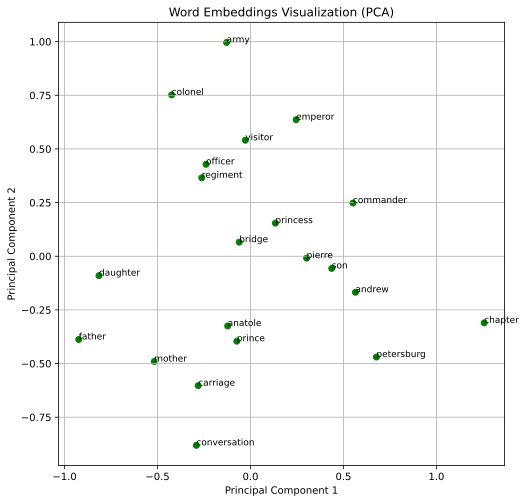

In [22]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# Define PCA to reduce from 50 dimensions to 2
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Plot the 2D word embeddings
plt.figure(figsize=(8, 8))
plt.scatter(result[:, 0], result[:, 1],color='green')

# Annotate each word in the plot
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=9)

plt.title('Word Embeddings Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


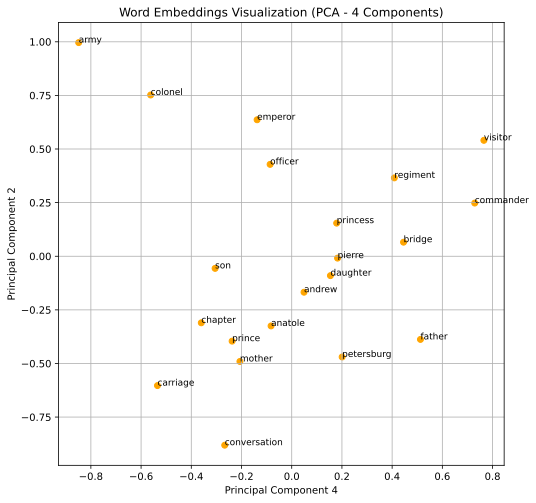

In [23]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# Perform PCA to reduce the dimensionality to 4 components
pca = PCA(n_components=4)
result = pca.fit_transform(X)

# Plot 4th and 2nd principal components
plt.figure(figsize=(8, 8))
plt.scatter(result[:, 3], result[:, 1],color='orange')

# Annotate each word on the plot
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 3], result[i, 1]), fontsize=9)

plt.title('Word Embeddings Visualization (PCA - 4 Components)')
plt.xlabel('Principal Component 4')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


What do you infer from the above 2 plots??

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, save the notebook as an .ipynb file (on Google Colab: File -> Download -> Download .ipynb)
4. Look at the notebook file and make sure all your solutions are there, displayed correctly. The notebook is the only thing your graders will see!
5. Submit your notebook, as well as a URL to a Google Colab copy of your notebook via Canvas.  The Google Colab link should be obtained from the Share option - please ensure that in the Share options, the General access is set to Anyone with the link.
